In [278]:
import requests
from bs4 import BeautifulSoup
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Overview

In this section, we want to identify which companies can be approached for internships in data science. There are many ways that this question can be approached, but we decided to focus on two main features of companies: their ratings and salary for. These two features are chosen because of they can be obtained from a number of job search platform including Glassdoor, Workopoli, indeed among others.
* Salary as a feature was chosen because it tends to reflect how much responsibility a job entails and most often the company's size or resources. Data on Salary for data science related jobs is obtained from the workopolis platform.
* Ratings are also used because they reflect public opinion about the company. We are using glassdoor to get companies' ratings. For each company associated with a job posting, ratings on career opportunities, benefits, culture & values, senior management, work/life balance are included as well as the overall company ratings. We will look at all these ratings to score a company.



## Glassdoor and Ratings

As discussed above, we will be using Glassdoor to get ratings of different companies, which will later help in identifying which companies to choose. The following process will be used:
* Web scapping Glassdoor to get the ratings features and basic company information
* Visualize and analyse the data obtained above to make the final decision

### Web Scrapping

In this step, we extract company details and ratings from Glassdoor. Rhe following features are extracted:
* Ratings including career opportunities, benefits, culture & values, senior management, work/life balance and overall ratings
* Company details including, the name and its industry

Note that selenium library and XPath are used in addition to beautiful to BeautifulSoup to parse and extract data from glassdood pages. When Glassdoor loads pages, details like ratings, reviews for a specific job are provided under different tabs. However, BeautifulSoup doesn't have the capability to parse a non static page. Thus, selenium's webdriver is used to overcome that problem (i.e can navigate different pages or dynamic content of the page). 

In [214]:
import time

options = webdriver.ChromeOptions()

#Make sure to download chromedriver (https://chromedriver.storage.googleapis.com/index.html?path=86.0.4240.22/) 
#and the executable to PATH or current working directory
driver = webdriver.Chrome(executable_path = "./chromedriver", options=options)

Here, we define a helper function that extracts the discussed features from data science job postings on Glassdoor. Note that the function call was commented out as the runtime is long; uncomment it if new data is needed. All data that was retrieved initially is saved in glassdoor_ratings.csv file.

In [215]:
types = ['Overall', 'Culture & Values', 'Work/Life Balance', 'Senior Management', 'Comp & Benefits', 'Career Opportunities']

def get_glassdoor_ratings():
    
    #initialize dataframe that will contain the scraped data
    ratings_df = pd.DataFrame()
    
    pages = list(range(0,1000,20))
    
    # glassdoor has about 20 jobs per page. GO through every page
    for page in pages:
        url = "https://www.glassdoor.ca/Job/toronto-data-science-jobs-SRCH_IL.0,7_IC2281069_KO8,20_IP" + str(page) + ".htm"
        driver.get(url)
        
        #Retrieve every job on current page and scrape them
        jobs = driver.find_elements_by_class_name("jl")

        for job in jobs:
            details = {}
            job.click()
            time.sleep(5)

            # get company name and job title
            try:
                company = driver.find_element_by_xpath('.//div[@class="employerName"]').text.split("\n")[0]
            except:
                company = None
                
            try:
                job_title = driver.find_element_by_xpath('.//div[contains(@class, "title")]').text
            except:
                job_title = None

            try:
                #Get company ratings: overall rating
                driver.find_element_by_xpath('.//div[@data-test="tab" and @data-tab-type="rating"]').click()
                overall_rating = driver.find_element_by_xpath('.//span[@class="avg"]').text

                #Get all other ratings
                soup = BeautifulSoup(driver.page_source, 'html.parser')

                rating_types = ['Overall']
                for rtype in soup.find_all(class_ = "ratingType"):
                    #text = rtype.text.lower()
                    #text = text.replace("&", "").replace(" ", "")

                    rating_types.append(rtype.text)

                ratings = [float(overall_rating)]
                for rating in soup.find_all(class_ = "ratingValue"):
                    rating = float(re.findall(r"[-+]?\d*\.\d+|\d+", rating.text)[0])
                    ratings.append(rating)

                details = dict(zip(types, ratings))
            except:
                details = dict(zip(rating_types, [None, None, None, None, None, None]))
                
            try:
                #Get the company's industry
                driver.find_element_by_xpath('.//div[@data-test="tab" and @data-tab-type="overview"]').click()
                industry = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Industry"]//following-sibling::*').text
            except:
                industry = None

            details['Industry'] = industry
            details['Company'] = company
            details['Title'] = job_title
            #add all the details to the dataframe
            ratings_df = ratings_df.append(details, ignore_index=True)
    return ratings_df

In [216]:
#uncoment if new data is needed
#ratings_df = get_glassdoor_ratings()
#ratings_df.head()

#ratings_df = ratings_df[pd.notna(ratings_df['Overall'])]
#ratings_df.to_csv('./glassdoor_ratings.csv', index=True)

### Visualization and Analysis

After we have the data, let's take a look at what the data looks like and draw some conclusion to answer the question.

In [260]:
#Read in the already saved data
ratings_df = pd.read_csv('glassdoor_ratings.csv')
ratings_df.drop(['Unnamed: 0'], axis=1, inplace=True)
ratings_df.head()

,Career Opportunities,Comp & Benefits,Company,Culture & Values,Industry,Overall,Senior Management,Title,Work/Life Balance,Diversity & Inclusion
0,2.9,2.5,Spin Master Ltd,3.0,Consumer Products Manufacturing,3.0,2.2,"Senior Manager, Data Science",3.2,NaN
1,3.8,4.2,Ian Martin,4.4,Staffing & Outsourcing,4.2,4.3,Data Engineer - BNSJP00016223,4.6,NaN
2,3.3,3.6,Softchoice,4.1,IT Services,3.7,3.8,Customer Insights Program Manager,4.4,NaN
3,3.4,3.4,HUB International,3.7,Insurance Agencies & Brokerages,3.6,3.6,Data Analyst (Insurance),4.2,NaN
4,3.9,3.8,Enhance IT,4.0,NaN,4.1,4.0,Big Data Engineer,5.0,NaN


In [261]:
ratings_df.drop_duplicates(subset=['Company'], keep='first', inplace=True)

#Drop the column since almost all companies don't have that rating
#ratings_df.drop(['Diversity & Inclusion'], axis=1, inplace=True)

#creat average rating column: to be of use during visualization
ratings_df['avg_rating'] = ratings_df[types].sum(axis=1)
ratings_df.sort_values(by=['avg_rating'], ascending=False, inplace=True)
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 77 to 11
Data columns (total 11 columns):
Career Opportunities     55 non-null float64
Comp & Benefits          55 non-null float64
Company                  66 non-null object
Culture & Values         55 non-null float64
Industry                 64 non-null object
Overall                  66 non-null float64
Senior Management        55 non-null float64
Title                    66 non-null object
Work/Life Balance        55 non-null float64
Diversity & Inclusion    0 non-null float64
avg_rating               66 non-null float64
dtypes: float64(8), object(3)
memory usage: 6.2+ KB


From the first glance at the data, all companies present in the dataset don't have Diversity & Inclusion rating, so we will drop that rating. 

Since we are looking into companies for potential internships, some ratings are going to be more important than others. That is, it is reasonable to say that a Career Opportunities rating is more likely important than a Senior Management rating. Thus, for visualization, we will focus mainly on Career Opporunities, Culture & Values, Work/Life balance and the overall ratings.

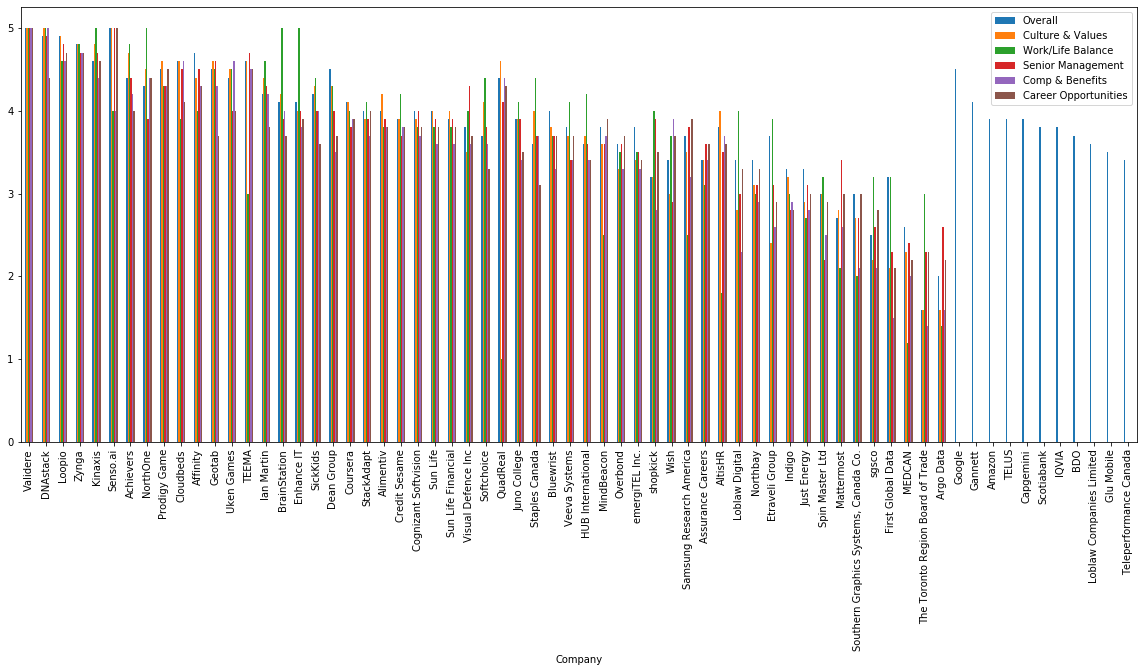

In [293]:
ratings_df.plot(x="Company", y=types, kind="bar", figsize=(20,8))
plt.show()

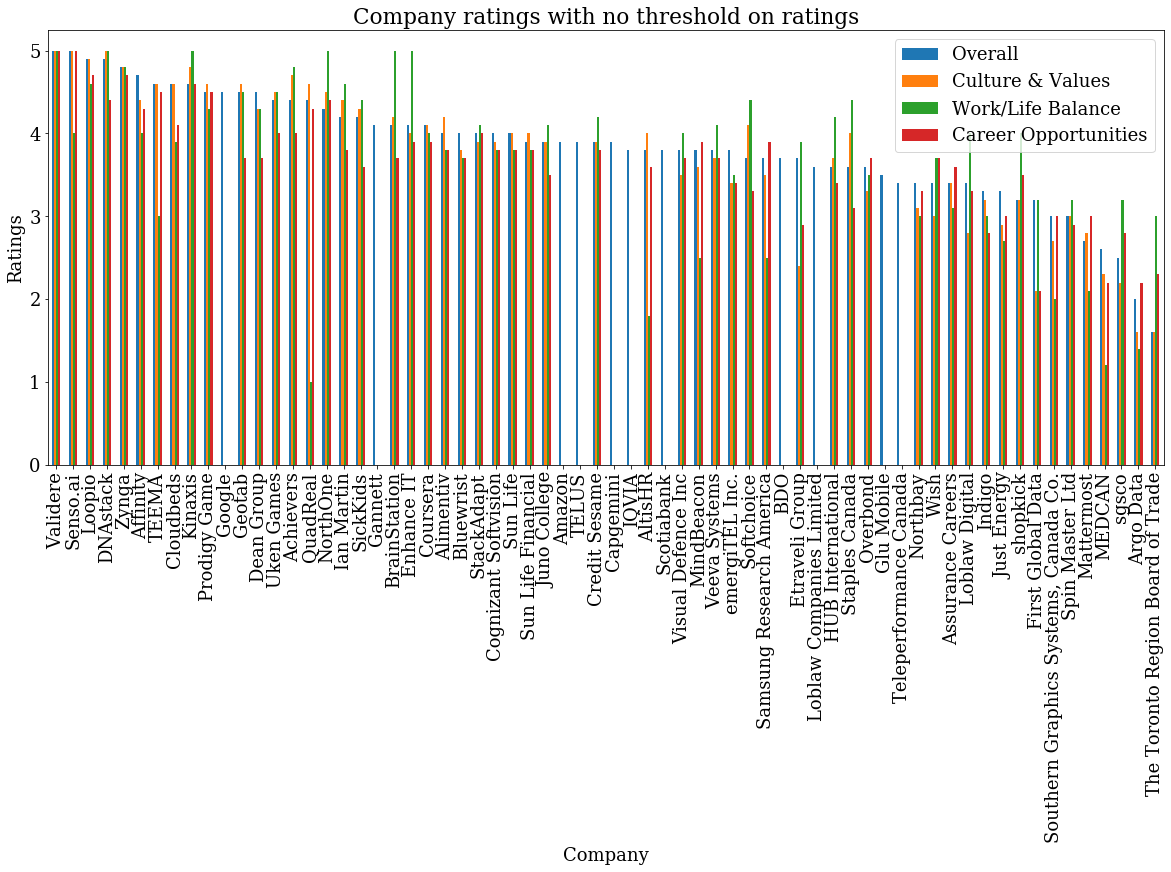

In [300]:
high_rating = ratings_df.sort_values(by=['Overall'], ascending=False)

font = {'font.family' : 'serif',
        'font.size'   : 18,
        'font.weight' : 'normal'}
plt.rcParams.update(font)

ax = high_rating.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'],
                 kind="bar", figsize=(20,8), title="Company ratings with no threshold on ratings")
ax.set_ylabel("Ratings")
plt.show()

The above plot is clearly not very legible as there are still many companies being visualized. However, if we are looking for companies to approach, it is reasonable to set a threshold rating below which the company is not considered. Let's set a threshold of an overall rating of 4

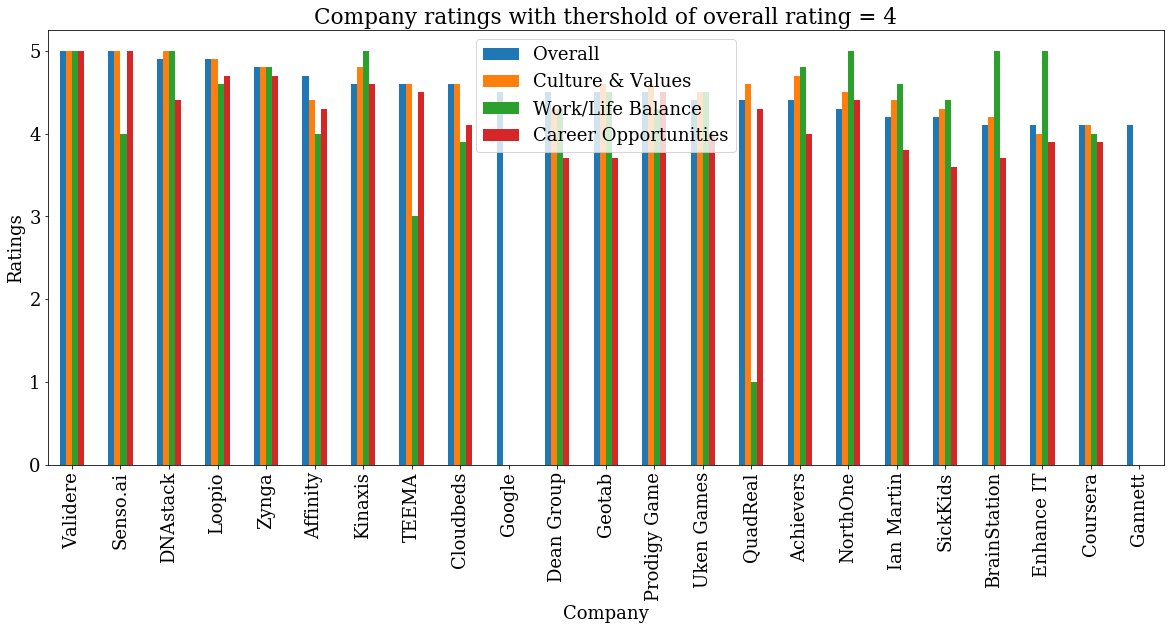

In [299]:
#Only companies with high overall rating
high_rating = ratings_df[ratings_df['Overall'] > 4].sort_values(by=['Overall'], ascending=False)

font = {'font.family' : 'serif',
        'font.size'   : 18,
        'font.weight' : 'normal'}
plt.rcParams.update(font)

ax = high_rating.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'],
                 kind="bar", figsize=(20,8), title="Company ratings with thershold of overall rating = 4")
ax.set_ylabel("Ratings")
plt.show()

From the plot above, companies like Validere, Senso.ai, DNAstack, Loopio, Zynga, Affinity among others have the highers overall rating. 

Given, we are looking for potential companies for internships, it is reasonable to look for companies that have available/potential opportunities. So, let's set a threshold for the Career Opportunities rating (of 4) in addition to the existing overall rating threshold.

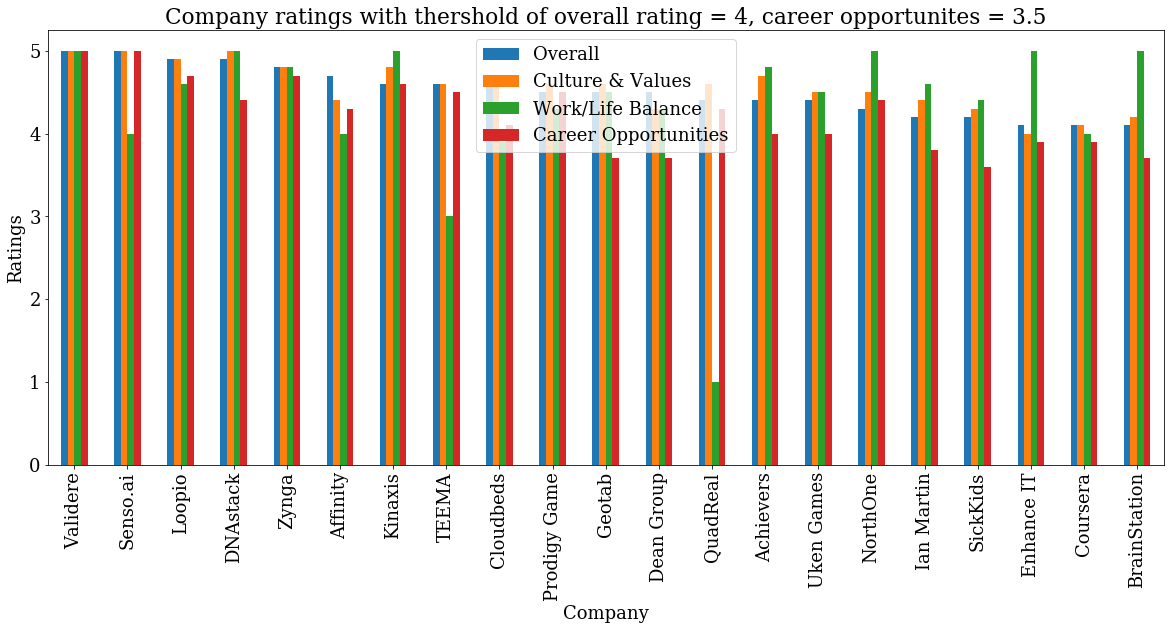

In [298]:
# Companies with high ratings and high career opportunities ratings (useful info for interns)
high_rating = ratings_df[(ratings_df['Overall'] > 4) & (ratings_df['Career Opportunities'] > 3.5)].sort_values(
    by=['Overall','Career Opportunities'], ascending=False)

font = {'font.family' : 'serif',
        'font.size'   : 18,
        'font.weight' : 'normal'}
plt.rcParams.update(font)

ax = high_rating.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'], 
                 kind="bar", figsize=(20,8),title="Company ratings with thershold of overall rating = 4, career opportunites = 3.5")
ax.set_ylabel("Ratings")
plt.show()

From the plot above, it is clear that most of the top companies from the previous plots are still at the top in the above plot too. Note that some companies like SickKids moved to the top 20 when the Career Opportunities threshold was introduced.

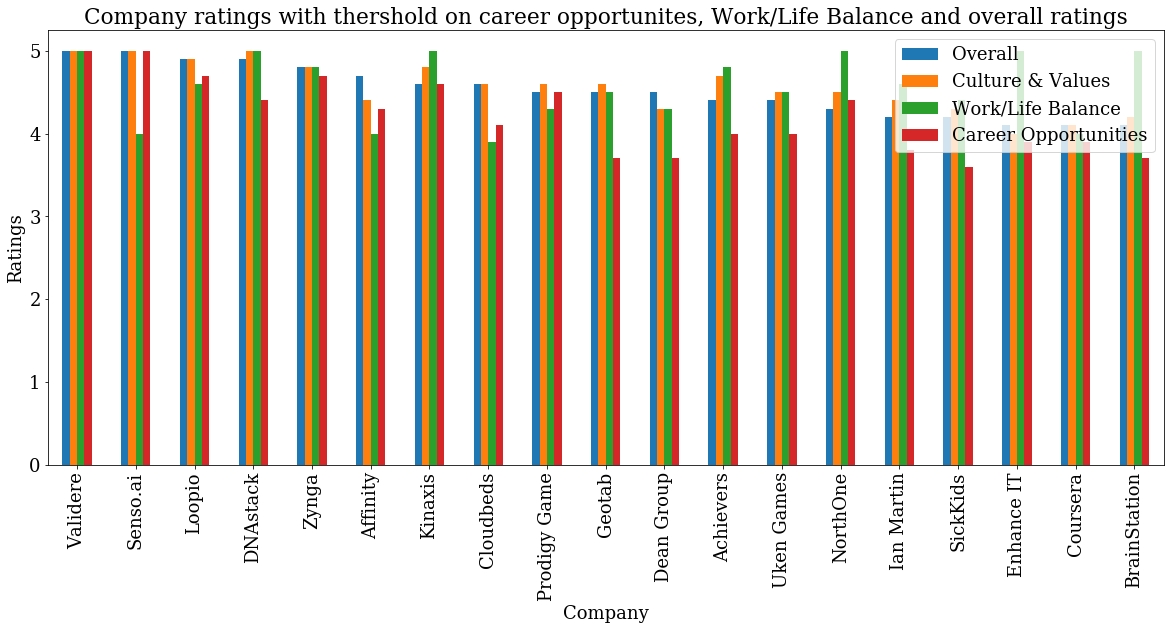

In [347]:
high_rating = ratings_df[(ratings_df['Overall'] > 4) & (ratings_df['Career Opportunities'] > 3.5) & 
                         (ratings_df['Work/Life Balance'] > 3.5)].sort_values(by=['Overall','Career Opportunities',
                                                                                 'Work/Life Balance'], ascending=False)
font = {'font.family' : 'serif',
        'font.size'   : 18,
        'font.weight' : 'normal'}
plt.rcParams.update(font)
             
ax = high_rating.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'], 
                 kind="bar", figsize=(20,8),
                      title="Company ratings with thershold on career opportunites, Work/Life Balance and overall ratings")
ax.set_ylabel("Ratings")
plt.show()

From the above plot, the top companies from previous plots are at the top again. 

In [348]:
high_rating[['Company','Industry','Title']]

,Company,Industry,Title
77,Validere,Energy,Data Scientist
37,Senso.ai,Enterprise Software & Network Solutions,Account Executive
64,Loopio,Enterprise Software & Network Solutions,Data Scientist
25,DNAstack,Enterprise Software & Network Solutions,Genomics Data Science Lead
24,Zynga,Video Games,Data Scientist II
26,Affinity,Enterprise Software & Network Solutions,Data Analyst
43,Kinaxis,Enterprise Software & Network Solutions,Principal Data Engineer (Analytics Solutions)
45,Cloudbeds,Computer Hardware & Software,Principal Data Engineer (Remote)
8,Prodigy Game,Computer Hardware & Software,"Data Scientist, Game"
52,Geotab,Computer Hardware & Software,"Data Scientist, Video Analytics"


In [281]:
ratings_df.groupby(['Industry']).size()

Industry
Accounting                                 1
Advertising & Marketing                    4
Audiovisual                                1
Banks & Credit Unions                      1
Biotech & Pharmaceuticals                  2
Cable, Internet & Telephone Providers      1
Colleges & Universities                    1
Computer Hardware & Software               9
Consumer Products Manufacturing            1
Education Training Services                2
Energy                                     1
Enterprise Software & Network Solutions    8
Federal Agencies                           1
Health Care Services & Hospitals           3
IT Services                                3
Insurance Agencies & Brokerages            1
Insurance Carriers                         2
Internet                                   5
Investment Banking & Asset Management      1
Membership Organizations                   1
Other Retail Stores                        1
Parking Lots & Garages                     1
P

Mention that the choices are arbitrary, and from narrowing down the places, one can choose ones in a desired industry

## Workopolis

In [282]:
# Code adapted from Group 15 in-class presentation

def scrape_workopolis():
    job_info = pd.DataFrame()

    # For workopolis, each page only displays ~25 jobs

    base = "https://www.workopolis.com"
    w_link = "https://www.workopolis.com/jobsearch/find-jobs?ak=data+science&lg=en&pn="
    result = ""
    for i in range(1,15):
        page = w_link + str(i)
        curr_r = requests.get(page).text
        result = result + curr_r

    soup = BeautifulSoup(result, 'lxml')

    for jobs in soup.find_all("article",class_ = "JobCard"): 
      try:
        position_title = jobs.find('h2', class_ = 'JobCard-title').text.strip()
      except:
        position_title = None

      try:
        employer = jobs.find('div',attrs={'class': 'JobCard-property JobCard-company'}).find('span').text.strip()
      except:
        employer = None

      try:
        location = jobs.find('span', class_ = 'JobCard-property JobCard-location').text.strip()
      except:
        location = None

      try:
        link = jobs.find('h2', attrs={'class': 'JobCard-title'}).find('a', href=True)['href']
      except:
        link = None

      try:
        salary = jobs.find('span', class_ = 'Salary').text.strip()
      except:
        location = None

      job_info = job_info.append({
          'position_title': position_title, 
          'employer': employer,
          'location': location,
          'link': link,
          'estimated_salary': salary}, ignore_index = True)
    return job_info

In [292]:
#jobs_df = scrape_workopolis()
#jobs_df.to_csv('./workopolis_jobs.csv', index=True)

In [310]:
#Read in the already saved data
jobs_df = pd.read_csv('workopolis_jobs.csv')
jobs_df.drop(['Unnamed: 0'], axis=1, inplace=True)
jobs_df.head()

,employer,estimated_salary,link,location,position_title
0,Société Conseil Groupe LGS,"$65,000 - $120,000 a year",/jobsearch/viewjob/B1WzUSCL08V4fHKqPSuVmt-ScDl...,"— Montréal, QC",Architecte de solutions AI
1,Spin Master Ltd,"Estimated: $84,000 - $120,000 a year",/jobsearch/viewjob/CAV4qCvR7aX0DbTTtqlSuqAU6bQ...,"— Toronto, ON","Senior Manager, Data Science"
2,MSi Corp (Bell Canada),$60 - $70 an hour,/jobsearch/viewjob/vIutwtUUWteTuDjx9sbKUTlmnWN...,"— Montréal, QC",Senior BI Manager
3,Yelp,"Estimated: $64,000 - $87,000 a year",/jobsearch/viewjob/yMpYOTSrFli_UUO9o5DHYfyVuYr...,— Remote,Data Analyst (Remote)
4,LeapGrad Corp.,"Estimated: $48,000 - $67,000 a year",/jobsearch/viewjob/yY1D_g2NnZitlS5SYVFUPA06lqF...,"— Toronto, ON",Data Science Intern (New Grads) - Starts Novem...


In [312]:
#Clean the salary data
hourly_rate = jobs_df[jobs_df['estimated_salary']. apply(lambda x: x.find('hour') != -1)]
#print(len(hourly_rate))

#Since the hourly rate jobs are very few, they will be dropped from the dataframe for consistency in salary
jobs_df.drop(hourly_rate.index, inplace=True)

#drop rows where salary is null
jobs_df.drop(jobs_df[pd.isna(jobs_df['estimated_salary'])].index, inplace=True)


9


In [336]:
# Given we are working within an internship context, will extract only the lower salary of the salary range 
#given in the estimated_salary column for purposes of vizualization

def clean_salary(salary):
    salary = salary.replace('Estimated:', '')
    salary = salary.replace ('a year', '').strip()
    range_salary = salary #keep the range of the salaries
    #get only the lower of the range
    salary = salary.split('-')[0]
    salary = int(salary.replace('$', '').replace(',', ''))
    
    return salary

In [337]:
jobs_df['salary'] = jobs_df['estimated_salary'].apply(clean_salary)
jobs_df.head()

,employer,estimated_salary,link,location,position_title,salary
0,Société Conseil Groupe LGS,"$65,000 - $120,000 a year",/jobsearch/viewjob/B1WzUSCL08V4fHKqPSuVmt-ScDl...,"— Montréal, QC",Architecte de solutions AI,65000
1,Spin Master Ltd,"Estimated: $84,000 - $120,000 a year",/jobsearch/viewjob/CAV4qCvR7aX0DbTTtqlSuqAU6bQ...,"— Toronto, ON","Senior Manager, Data Science",84000
3,Yelp,"Estimated: $64,000 - $87,000 a year",/jobsearch/viewjob/yMpYOTSrFli_UUO9o5DHYfyVuYr...,— Remote,Data Analyst (Remote),64000
4,LeapGrad Corp.,"Estimated: $48,000 - $67,000 a year",/jobsearch/viewjob/yY1D_g2NnZitlS5SYVFUPA06lqF...,"— Toronto, ON",Data Science Intern (New Grads) - Starts Novem...,48000
5,RBC,"Estimated: $82,000 - $110,000 a year",/jobsearch/viewjob/5WvuKS8RHDHbPOUOgcp7UDpTmpd...,"— Toronto, ON",Data Analyst - AI,82000


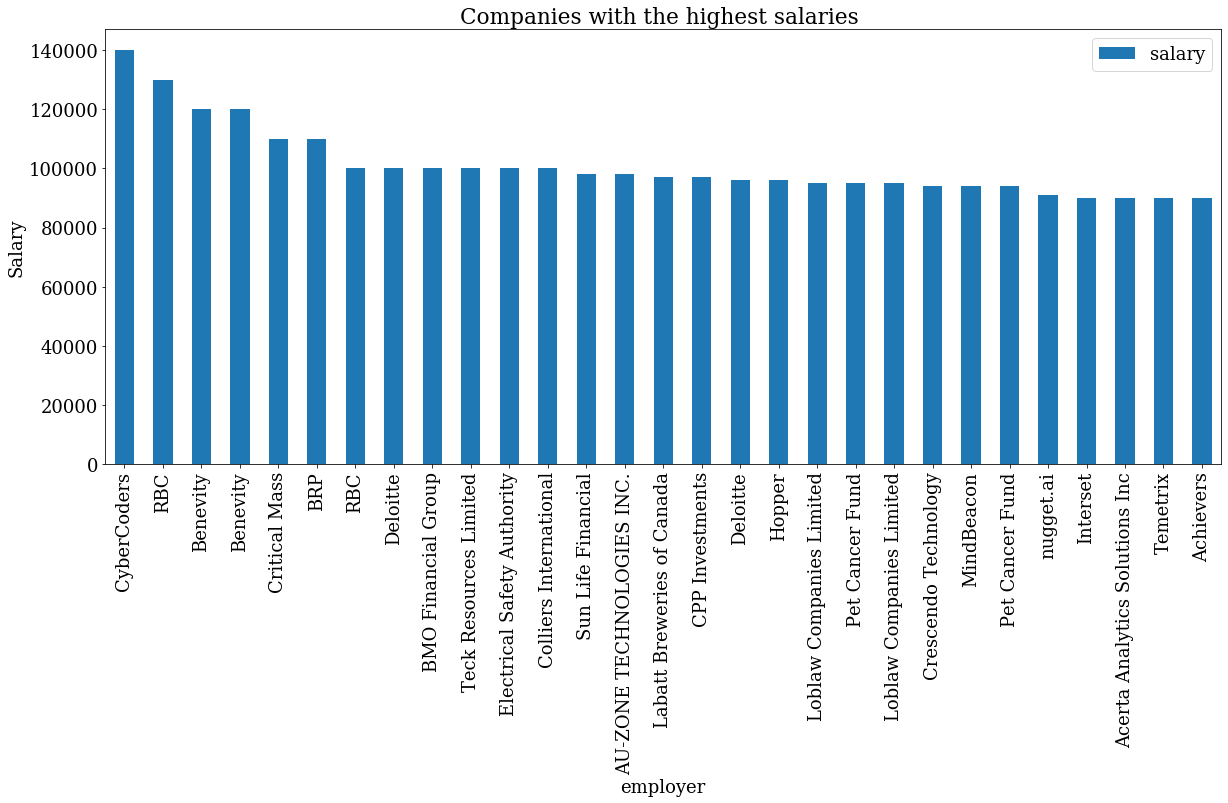

In [368]:
high_salary = jobs_df.sort_values(by=['salary'], ascending=False).iloc[:29, :]
ax = high_salary.plot(x="employer", y=['salary'], 
                 kind="bar", figsize=(20,8), title="Companies with the highest salaries ")
ax.set_ylabel("Salary")
plt.show()

In [352]:
jobs_df['employer_lc'] = jobs_df['employer'].apply(lambda x: str(x).lower().strip())
jobs_df.head()

,employer,estimated_salary,link,location,position_title,salary,employer_lc
0,Société Conseil Groupe LGS,"$65,000 - $120,000 a year",/jobsearch/viewjob/B1WzUSCL08V4fHKqPSuVmt-ScDl...,"— Montréal, QC",Architecte de solutions AI,65000,société conseil groupe lgs
1,Spin Master Ltd,"Estimated: $84,000 - $120,000 a year",/jobsearch/viewjob/CAV4qCvR7aX0DbTTtqlSuqAU6bQ...,"— Toronto, ON","Senior Manager, Data Science",84000,spin master ltd
3,Yelp,"Estimated: $64,000 - $87,000 a year",/jobsearch/viewjob/yMpYOTSrFli_UUO9o5DHYfyVuYr...,— Remote,Data Analyst (Remote),64000,yelp
4,LeapGrad Corp.,"Estimated: $48,000 - $67,000 a year",/jobsearch/viewjob/yY1D_g2NnZitlS5SYVFUPA06lqF...,"— Toronto, ON",Data Science Intern (New Grads) - Starts Novem...,48000,leapgrad corp.
5,RBC,"Estimated: $82,000 - $110,000 a year",/jobsearch/viewjob/5WvuKS8RHDHbPOUOgcp7UDpTmpd...,"— Toronto, ON",Data Analyst - AI,82000,rbc


In [366]:
companies_gd = high_rating['Company'].apply(lambda x: str(x).lower().strip())
with_salaries = jobs_df[jobs_df['employer_lc'].apply(lambda x: x in set(companies_gd))]
with_salaries.drop_duplicates(subset=['employer_lc'], keep='last', inplace=True)
with_salaries = with_salaries[['employer', 'position_title', 'salary']].sort_values(by=['salary'], ascending=False)
with_salaries

C:\Users\merci\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,employer,position_title,salary
32,Achievers,Data Scientist,90000
97,Dean Group,Machine Learning Engineer,87000
267,Coursera,"Senior Data Scientist, Machine Learning",84000
166,Kinaxis,Data Scientist,83000
222,SickKids,Senior Data Architect- Artificial Intelligence...,81000
349,Geotab,Senior Data Scientist,81000
35,NorthOne,Data Scientist,75000
137,Loopio,Data Scientist,72000
21,DNAstack,Genomics Data Science Lead,67000
129,BrainStation,"Associate Educator, Data Scientist",62000


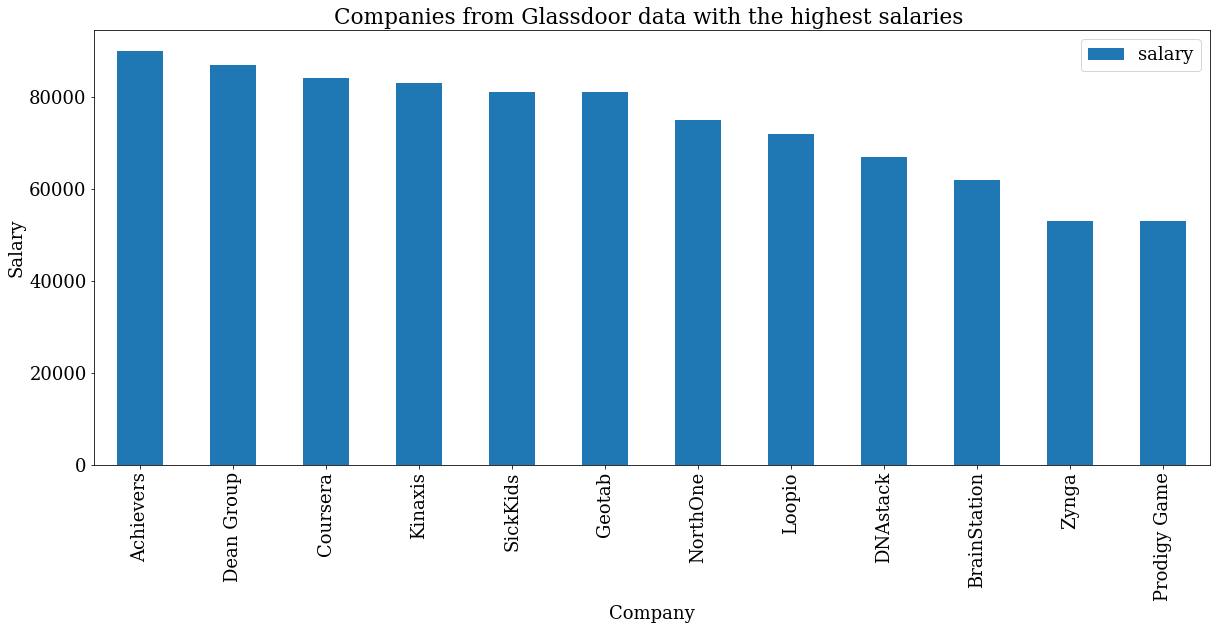

In [370]:
ax = with_salaries.plot(x="employer", y=['salary'], 
                 kind="bar", figsize=(20,8), title="Companies from Glassdoor data with the highest salaries ")
ax.set_ylabel("Salary")
ax.set_xlabel("Company")
plt.show()

## Indeed

In [ ]:
# Scrape indeed website, and store results in dataframe job_info
job_info = pd.DataFrame()
base = 'http://ca.indeed.com'
# Indeed displays ~10-15 jobs on each page, while each job itself can be identify as a page.
# So we search jobs every 10 pages.
# For 1000+ jobs, we need to go through 100+ pages with 10+ jobs on each page. 
import requests
pages = list(range(0,1100,10))
for page in pages:
  result = requests.get("https://ca.indeed.com/jobs?q=data+scientist&start="+str(page)).text
  soup = BeautifulSoup(result, 'lxml')
  
  for jobs in soup.find_all(class_ = "result"): 
    
    try:
      position_title = jobs.find('a', class_='jobtitle turnstileLink').text.strip()
    except:
      position_title = None
      
    try:
      employer = jobs.find('span', class_='company').text.strip()
    except:
      employer = None

    try:
      location = jobs.find('span', class_='location').text.strip()
    except:
      location = None
      
    try:
      salary = jobs.find('span', class_ = 'salaryText').text.strip()
    except:
      salary = None

    try:
      link = base + jobs.find('a').attrs['href']
    except:
      link = None
    
    job_info = job_info.append({
        'position_title': position_title, 
        'employer': employer,
        'location': location,
        'salary': salary,
        'link': link}, ignore_index = True)

#Delect dulicate jobs
job_info = job_info.drop_duplicates(['link'], keep='first')


In [ ]:
job_info.head(20)

In [ ]:
job_info["position_title"] = job_info["position_title"].replace('', np.nan)
job_info = job_info.dropna(subset=['position_title'])
job_info.shape

### Job breakdown details by location

In [ ]:
location = job_info.groupby("location")
location.describe().head()

In [ ]:
plt.figure(figsize=(15,10))
location.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Location")
plt.ylabel("Number of Jobs")
plt.show()

Based on this plot, we can see the most popular city in Canada for data science positions is Toronto by far.

### Job breakdown details by employer

In [ ]:
company = job_info.groupby("employer")
company.describe().head()

In [ ]:
plt.figure(figsize=(15,10))
company.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Companies")
plt.ylabel("Number of Jobs")
plt.show()

### Job breakdown details by skills

In [ ]:
# List possible skill requirements
technical_skill = ['excel', 'python', 'r', 'java', 'c', 'c++', 'matlab', 'sas','sql', 
                   'tableau', 'hadoop', 'spark','power bi',
                   'tensorflow', 'keras','pytorch','theano','caffe']
business_skill = ['communication', 'problem solving', 'project management', 'consulting', 
                  'presentation', 'leadership', 'documentation', 'marketing','lead', 
                  'time management', 'collaborate', 'organize']
skills = technical_skill + business_skill 
# Add columns for skills
for skill in skills:
  job_info[skill] = np.zeros(len(job_info))


job_info.head()

In [ ]:
job_info = job_info.reset_index()
job_info.head(5)

In [ ]:
# Confirm that column 2 is the column for job detail link
job_info.iloc[1,2]

In [ ]:
# For each job, check its job details/description page
# to collect the required skills.
# Set skill entries to 1 if they are mentioned in job details


for i in range(len(job_info)):
  link = requests.get(job_info.iloc[i,2])
  soup = BeautifulSoup(link.text, "lxml")
  try:
    text = soup.find('div', class_ = 'jobsearch-jobDescriptionText').text.strip().lower()
    # Preprocessing, replace punctuations, and replace multiple spaces
    text = re.sub(r'\,', ' ', text) 
    text = re.sub('/', ' ', text) 
    text = re.sub(r'\(', ' ', text) 
    text = re.sub(r'\)', ' ', text) 
    text = re.sub(' +',' ',text) 
  except:
    text = ""

  for s in skills :
    # This is specifically for C++, escape the ++. Convert C++ to C\+\+
    if any(x in s for x in ['+']):
      skill = re.escape(s)
    else:
      skill = s
    matching = re.search(r'(?:^|(?<=\s))' + skill + r'(?=\s|$)',text)
    if matching:
      job_info[s][i] = 1
      #print("matched skill ",s, "for job ",str(i+1))
job_info.head(10)

# Sanity check
job_info['excel'].sum()

In [ ]:
import matplotlib.pyplot as plt
df_tech = job_info[technical_skill]
tech_count = df_tech.sum()
tech_count = tech_count.sort_values(ascending=False)
df_tcount = pd.DataFrame(data=tech_count,columns=["Count"])
df_tcount.index.name = "Technical Skills"
df_tcount
#plt.bar(,tech_count.to_list)

In [ ]:
df_tcount.plot(kind="bar")
plt.title('Technical Skills Demand for Data Science Jobs on Indeed.ca')